## Removing Amphora Handles

### Plan:

1. Using the _Morphological Geodesic Active Contour_ method, get the contour depicting the outline of the pot.
1. Since, for now, we want one side of the pot, choose the best side.
    To do this, check which side has the longest contour and choose the side with the shortest contour length.
1. Estimate the area where a handle can be found, (whether it's the left or right handle, depends on the previous step).
1. Use the snake method (or _active contour_), to locate the handle.
1. Get innermost side of handle.
1. Find the point just below the lid, where the handle starts, $p_{1}$.
1. Find the point on the pot, where the handle ends, $p_{2}$.
1. Starting from the top of the pot (the lid), travel along the pot outline, to $p_{1}$. Then, from $p_{1}$, cut to the the side of the handle and travel across this. Finally, after traversing the handle, cut to point $p_{2}$ on the pot and continue travelling along the pot, until you get to the end of the pot contour.


### Code:

#### Imports

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pylab as pl
from math import sqrt
from skimage.filters import threshold_otsu
from skimage import measure
import os
import re
import itertools as it
import csv
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
pl.ion()

#### Contour Outline Functions

In [2]:
def get_pot_outline_contour(image):
    gimage = inverse_gaussian_gradient(image)
    # Initial level set
    init_ls = np.zeros(image.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1
    ls = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                               smoothing=1, balloon=-1,
                                               threshold=0.69)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    v = ax.contour(ls, [0.5], colors='r')
    t = v.collections[0].get_paths()
    k = 0
    for i in range(0,len(t)):
        if len(t[i]) >= len(t[k]):
            k = i
    X, Y = v.collections[0].get_paths()[k].vertices.T
    plt.close()
    return X,Y

In [3]:
def get_shortest_side(X,Y):
    top_pnt = np.argmax(Y)
    bot_pnt = np.argmin(Y)

    mx_pnt = max(top_pnt,bot_pnt)
    mn_pnt = min(top_pnt,bot_pnt)

    xs1 = list(X[mn_pnt:mx_pnt])
    ys1 = list(Y[mn_pnt:mx_pnt])

    xs2 = list(X)[mx_pnt:] + list(X)[:mn_pnt] 
    ys2 = list(Y)[mx_pnt:] + list(Y)[:mn_pnt] 
    
    if min(xs1) > min(xs2):
        D1 = "R"
        D2 = "L"
    else:
        D1 = "L"
        D2 = "R"

    if len(ys1) >= len(ys2):
        ys = ys2
        xs = xs2
        D = D2
    else:
        ys = ys1
        xs = xs1
        D = D1

    return xs,ys,D

In [4]:
def get_handle_contour(image,X,Y,D):
    topy = np.max(Y)
    boty = np.min(Y)
    topx = np.max(X)
    botx = np.min(X)
    tnth = round((topy - boty)/10,2)
    sxth = round((topx-botx)/6,2)
    c2 = boty + 2*tnth
    if D == "L":
        c1 = botx + sxth
    else:
        c1 = topx - sxth
    a = sxth/2
    b = tnth
    s = np.linspace(0, 2*np.pi, 400)
    xe = c1+a*np.cos(s)
    ye = c2+b*np.sin(s)
    init = np.array([xe,ye]).T
    snake = active_contour(gaussian(image, 3),init,w_line=-5)
    return snake[:,0],snake[:,1]

#### Handle Removal Code:

In [5]:
def get_top_bot_handle(x_,y_):

    mx = np.argmax(y_)
    mn = np.argmin(y_)
    ubt = np.max(y_)
    lbb = np.min(y_)
    ubb = ubt - ((ubt - lbb)/10)
    lbt = lbb + ((ubt - lbb)/10)

    bot = []
    top = []

    for i in range(0,len(x_)):
        if lbb <= y_[i] <= lbt:
            bot.append(i)
        if ubb <= y_[i] <= ubt:
            top.append(i)
    return top,bot

In [6]:
def get_handle_side(x_,y_,top,bot,D):
    if D == "L":
        p1 = np.argmin(x_[top])
        p2 = np.argmax(x_[bot])
    else:
        p1 = np.argmax(x_[top])
        p2 = np.argmin(x_[bot])

    p1 = top[p1]
    p2 = bot[p2]

    # Determine direction of contour.
    d_ = "L"
    if (x_[p2] > x_[p2-1]) or (x_[p2] > x_[p2-2]):
        d_ = "R"

    xh = []
    yh = []

    x_2 = list(x_)
    y_2 = list(y_)

    # Case 1:
    if (d_ == "R" and D == "L") or (d_ =="L" and D == "R"):
        if p1 > p2:
            xh = x_2[p2:p1]
            yh = y_2[p2:p1]
        else:
            xh = x_2[p2:]
            xh.extend(x_2[0:p1])
            yh = y_2[p2:]
            yh.extend(y_2[0:p1])
    # Case 2:        
    elif (d_ == "L" and D == "L") or (d_ =="R" and D == "R"):
        if p1 > p2:
            xh = x_2[p1:]
            xh.extend(x_2[0:p2])
            yh = y_2[p1:]
            yh.extend(y_2[0:p2])
        else:
            xh = x_2[p1:p2]
            yh = y_2[p1:p2]
    
    return xh,yh

In [7]:
def get_end_pot_lid(x,y,lb,ub,D,k):
    inds = []
    for i in range(1,len(x)-1):
        if lb < y[i] < ub:
            if k == 0:
                if D == "R":
                    if (x[i-1] >= x[i]) and (x[i+1] > x[i]):
                        inds.append(i)
                else:
                    if (x[i-1] <= x[i]) and (x[i+1] < x[i]):
                        inds.append(i)
            else:
                if D == "R":
                    if (x[i-1] >= x[i]) and (x[i+1] >= x[i]):
                        inds.append(i)
                else:
                    if (x[i-1] <= x[i]) and (x[i+1] <= x[i]):
                        inds.append(i)
    return inds

In [8]:
def get_amphora_contour(image_grey):
    
    # 1) Get pot and handle contours:
    x,y = get_pot_outline_contour(image_grey)
    
    # 2) Get shortest side of outline:
    xs,ys,d = get_shortest_side(x,y)
    
    #3) Fnid handle contour:
    xh,yh = get_handle_contour(image_grey,x,y,d)
    
    #4) Get side of handle:
    top,bot = get_top_bot_handle(xh,yh)
    xhs,yhs = get_handle_side(xh,yh,top,bot,d)
    
    #5) Locate end of pot lid:
    lb = min(ys)+(max(ys) - min(ys))/20
    ub = min(min(ys)+(max(ys) - min(ys))/10,min(yh))
    inds = get_end_pot_lid(xs,ys,lb,ub,d,0)
    
    if len(inds) == 0:
        inds = get_end_pot_lid(xs,ys,lb,ub,d,1)
        
    p1 = inds[0]
    
    #6) Find end of handle
    if ys[0] > ys[round(len(ys)/2)]:
        ys.reverse()
        xs.reverse()
    
    ub = max(yhs) + (max(yhs) - min(yhs))/5
        
    p2 = np.where(np.round(ys) > np.round(ub))[0][0]+1
    
    #7) Remove handles:    
    if yhs[0] > yhs[round(len(yhs)/2)]:
        yhs.reverse()
        xhs.reverse()
        
    p3 = np.argmax(yhs) 
    
    xr = []
    yr = []
    xr.extend(xs[:p1])
    yr.extend(ys[:p1])
    xr.extend(xhs[:p3])
    yr.extend(yhs[:p3])
    xr.extend(xs[p2:])
    yr.extend(ys[p2:])
            
    return xr,yr

#### Test:

In [9]:
image_grey = data.load('C:\\Users\\arian\\Dropbox\\arianna_phd\\Pots\\Original_Images\\amphora_51_London.bmp',as_gray=True)

In [10]:
x,y = get_amphora_contour(image_grey)

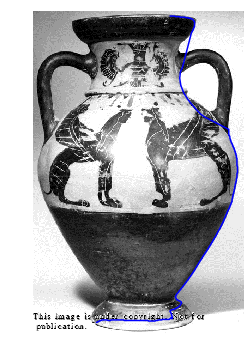

In [11]:
fig, ax = plt.subplots(figsize=(4, 6))

ax.imshow(image_grey, cmap="gray")
ax.set_axis_off()
ax.plot(x,y,'-b')
